# Compare mutation effects on ACE2 binding vs sera escape at key sites
This notebook compares how different mutations affect ACE2 binding versus escape at key sites.

In [1]:
# this cell is tagged as parameters for `papermill` parameterization
dms_csv = None
logoplot_subdir = None
min_cell_entry = None
min_mutations_at_site = None

In [2]:
import math
import os
import tempfile
import urllib.request

import altair as alt

import dmslogo

import matplotlib
import matplotlib.pyplot as plt

import numpy

import palettable

import pandas as pd

import polyclonal.pdb_utils

plt.rcParams['svg.fonttype'] = 'none'

os.makedirs(logoplot_subdir, exist_ok=True)

## Read input data

In [7]:

dms_df = (
    pd.read_csv(dms_csv)
    .rename(columns={"adult sera escape": "sera escape", "spike mediated entry": "cell entry"})
    .dropna(subset=["sera escape", "cell entry", "ACE2 binding"])
    .query("`cell entry` >= @min_cell_entry")
    .query("mutant not in ['*', '-']")  # exclude stop and gap
    .assign(
        mutation=lambda x: x["wildtype"] + x["site"].astype(str) + x["mutant"],
        n_mutations_at_site=lambda x: x.groupby("site")["mutant"].transform("count"),
    )
    .query("n_mutations_at_site >= @min_mutations_at_site")
    .reset_index(drop=True)
)

dms_df

site wildtype mutant  sera escape  cell entry  ACE2 binding  \
0     100        I      H     -0.07529    -0.04663       0.13530   
1     100        I      I      0.00000     0.00000       0.00000   
2     100        I      K     -0.09995    -1.46500       0.03624   
3     100        I      L      0.02544    -0.26160      -0.06846   
4     100        I      M      0.04990    -0.23630      -0.08508   
...   ...      ...    ...          ...         ...           ...   
3570   98        S      S      0.00000     0.00000       0.00000   
3571   98        S      T      0.04928     0.07060      -0.16440   
3572   98        S      V      0.04894     0.06945      -0.08503   
3573   98        S      W     -0.06070    -0.49820      -0.07883   
3574   98        S      Y      0.02466    -0.00219       0.03044   

      sequential_site region mutation  n_mutations_at_site  
0                  98    NTD    I100H                    8  
1                  98    NTD    I100I                    8  
2                  98    NTD    I100K                    8  
3                  98    NTD    I100L                    8  
4                  98    NTD    I100M                    8  
...               ...    ...      ...                  ...  
3570               96    NTD     S98S                   19  
3571               96    NTD     S98T                   19  
3572               96    NTD     S98V                   19  
3573               96    NTD     S98W                   19  
3574               96    NTD     S98Y                   19  

[3575 rows x 10 columns]

## Calculate correlation between ACE2 binding and escape for each site

In [8]:
# compute correlations
correlation_df = (
    dms_df
    .groupby("site")
    [["sera escape", "ACE2 binding"]]
    .corr()
    .reset_index()
    .query("level_1 == 'sera escape'")
    .rename(columns={"ACE2 binding": "correlation"})
    [["site", "correlation"]]
    .dropna(subset="correlation")
    .reset_index(drop=True)
)

# add correlations to DMS data frame
dms_df = dms_df.merge(correlation_df, validate="many_to_one")

dms_df

site wildtype mutant  sera escape  cell entry  ACE2 binding  \
0     100        I      H     -0.07529    -0.04663       0.13530   
1     100        I      I      0.00000     0.00000       0.00000   
2     100        I      K     -0.09995    -1.46500       0.03624   
3     100        I      L      0.02544    -0.26160      -0.06846   
4     100        I      M      0.04990    -0.23630      -0.08508   
...   ...      ...    ...          ...         ...           ...   
3570   98        S      S      0.00000     0.00000       0.00000   
3571   98        S      T      0.04928     0.07060      -0.16440   
3572   98        S      V      0.04894     0.06945      -0.08503   
3573   98        S      W     -0.06070    -0.49820      -0.07883   
3574   98        S      Y      0.02466    -0.00219       0.03044   

      sequential_site region mutation  n_mutations_at_site  correlation  
0                  98    NTD    I100H                    8    -0.829991  
1                  98    NTD    I100I                    8    -0.829991  
2                  98    NTD    I100K                    8    -0.829991  
3                  98    NTD    I100L                    8    -0.829991  
4                  98    NTD    I100M                    8    -0.829991  
...               ...    ...      ...                  ...          ...  
3570               96    NTD     S98S                   19    -0.643325  
3571               96    NTD     S98T                   19    -0.643325  
3572               96    NTD     S98V                   19    -0.643325  
3573               96    NTD     S98W                   19    -0.643325  
3574               96    NTD     S98Y                   19    -0.643325  

[3575 rows x 11 columns]

## Plot sites with high inverse correlation between ACE2 binding and escape
Plot sites with high inverse correlation of binding and escape; note the slider at the bottom can control which sites are shown:

In [9]:
# first make base chart

facet_size = 100

cell_entry_slider = alt.param(
    value=min_cell_entry,
    bind=alt.binding_range(
        name="minimum cell entry",
        min=dms_df["cell entry"].min(),
        max=0,
    ),
)

binding_escape_corr_base = (
    alt.Chart(dms_df)
    .add_params(cell_entry_slider)
    .transform_filter(alt.datum["cell entry"] >= cell_entry_slider)
)

binding_escape_corr_chart = (
    (
        (
            binding_escape_corr_base
            .encode(
                x=alt.X("ACE2 binding", scale=alt.Scale(nice=False, padding=6)),
                y=alt.Y("sera escape", scale=alt.Scale(nice=False, padding=6)),
                tooltip=[
                    "site",
                    "mutation",
                    alt.Tooltip("ACE2 binding", format=".2f"),
                    alt.Tooltip("sera escape", format=".2f"),
                    alt.Tooltip("cell entry", format=".2f"),
                ],
            )           
            .mark_circle(color="black", opacity=0.3, size=60)
        )
        + (
            binding_escape_corr_base
            .transform_regression("ACE2 binding", "sera escape", params=True)
            .transform_calculate(
                r=alt.expr.if_(
                    alt.datum["coef"][1] > 0,
                    alt.expr.sqrt(alt.datum["rSquared"]),
                    -alt.expr.sqrt(alt.datum["rSquared"]),
                ),
                r_text="r = " + alt.expr.format(alt.datum["r"], ".2f"),
            )
            .encode(
                text="r_text:N",
                x=alt.value(3),
                y=alt.value(facet_size - 6),
            )
            .mark_text(size=12, align="left", color="blue")
        )
    )
    .properties(width=facet_size, height=facet_size)
    .facet(
        facet=alt.Facet(
            "site",
            title=None,
            header=alt.Header(
                labelFontSize=14,
                labelFontStyle="italic",
                labelPadding=0,
                labelExpr="'site ' + datum.label",
            )
        ),
        spacing=8,
        columns=8,
    )
    .configure_axis(grid=False)
)

# now make chart filtered for strongly negative correlations
max_corr_slider = alt.param(
    value=-0.82,
    bind=alt.binding_range(
        name="only show sites with correlation r less than this",
        min=-1,
        max=1,
        step=0.01,
    ),
)

binding_escape_neg_corr_chart = (
    binding_escape_corr_chart
    .properties(
        title=alt.TitleParams(
            "Correlation of ACE2 binding and escape filtered by extent of negative correlation",
            anchor="middle",
            fontSize=16,
            dy=-5,
        ),
        autosize=alt.AutoSizeParams(resize=True),
    )
    .add_params(max_corr_slider)
    .transform_filter(alt.datum["correlation"] <= max_corr_slider)
)

binding_escape_neg_corr_chart

alt.FacetChart(...)

## We now plot the same correlation for sites of strong escape
We manually specify some sites of strong escape:

In [10]:
escape_sites = [50, 132, 200, 222, 332, 344, 357, 393, 428, 440, 458, 470, 475, 478, 505, 518, 572, 852]

binding_escape_high_escape_corr_chart = (
    binding_escape_corr_chart
    .properties(
        title=alt.TitleParams(
            "Correlation of ACE2 binding and escape for sites of strong escape",
            anchor="middle",
            fontSize=16,
            dy=-5,
        ),
        autosize=alt.AutoSizeParams(resize=True),
    )
    .transform_filter(alt.FieldOneOfPredicate("site", escape_sites))
)

binding_escape_high_escape_corr_chart

alt.FacetChart(...)

## Plot sites of top escape for mutations in different regions.
We plot both binding-escape correlation plots and logo plots for the sites with the most escaping mutations.

We stratify sites by:
 - RBD ACE2 proximal
 - RBD ACE2 distal
 - non-RBD

First get RBD sites distance from ACE2, and then use that to separate ACE2 proximal and distal:

In [12]:
ace2_proximal_cutoff = 15  # classify as ACE2 proximal if CA distance <= this

# chain A is ACE2, chain E is RBD
with tempfile.NamedTemporaryFile() as f:
    urllib.request.urlretrieve(
        "https://files.rcsb.org/download/6M0J.pdb",
        f.name,
    )
    coords_df = polyclonal.pdb_utils.extract_atom_locations(f.name, ["A", "E"], target_atom="CA")

# get closest distance for each residue in chain E (RBD) to residue in chain A (ACE2)
dist_df = (
    coords_df
    .query("chain == 'E'")
    [["site", "x", "y", "z"]]
    .merge(
        (
            coords_df
            .query("chain == 'A'")
            [["site", "x", "y", "z"]]
            .rename(columns={c: f"ACE2_{c}" for c in ["site", "x", "y", "z"]})
        ),
        how="cross",
    )
    .assign(
        distance=lambda x: x.apply(
            lambda r: math.sqrt(sum((r[c] - r[f"ACE2_{c}"])**2 for c in ["x", "y", "z"])),
            axis=1,
        )
    )
    .groupby("site", as_index=False)
    .aggregate({"distance": "min"})
)


In [21]:
# Keep only rows where 'site' is fully numeric
dms_df = dms_df[dms_df["site"].astype(str).str.match(r"^\d+$")].copy()

# Convert 'site' to int
dms_df["site"] = dms_df["site"].astype(int)

In [24]:
dms_df_by_region = (
    dms_df
    .merge(dist_df, how="left", validate="many_to_one")
    .assign(
        region=lambda x: numpy.where(
            (x["region"] == "RBD") & (x["distance"] <= ace2_proximal_cutoff),
            "RBD ACE2 proximal",
            numpy.where(x["region"] == "RBD", "RBD ACE2 distal", "non-RBD"),
        ),
    )
)

Now plot escape and binding for the sites with the top most escaping mutations in each region.
Make both correlation plots and logo plots colored by ACE2 binding:

Saving to ./results/binding_vs_escape/logoplots/ace2_scalebar_horizontal.svg


Saving to ./results/binding_vs_escape/logoplots/ace2_scalebar_vertical.svg


Analyzing top sites for region='RBD ACE2 distal'


alt.FacetChart(...)

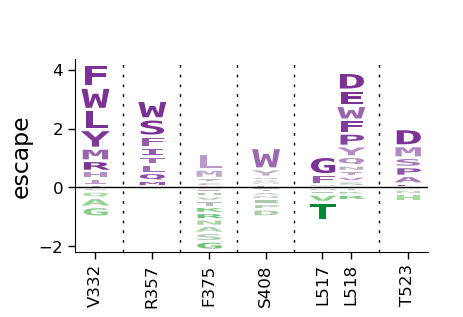

Saving to ./results/binding_vs_escape/logoplots/RBD_ACE2_distal_logoplot.svg


Analyzing top sites for region='RBD ACE2 proximal'


alt.FacetChart(...)

Saving to ./results/binding_vs_escape/logoplots/RBD_ACE2_proximal_logoplot.svg


Analyzing top sites for region='non-RBD'


alt.FacetChart(...)

Saving to ./results/binding_vs_escape/logoplots/non-RBD_logoplot.svg


Saving to results/binding_vs_escape/logoplots/non-RBD_logoplot.svg


In [25]:
top_n = 7

# for coloring by ACE2
ace2_colormap = dmslogo.colorschemes.ValueToColorMap(
    minvalue=-1.5,
    maxvalue=1.5,
    cmap=palettable.colorbrewer.diverging.PRGn_4.mpl_colormap,
    #cmap=palettable.colorbrewer.diverging.PuOr_4.mpl_colormap,
    #cmap=palettable.lightbartlein.diverging.BlueOrange8_2.mpl_colormap,
)
assert abs(ace2_colormap.minvalue) == ace2_colormap.maxvalue, "not symmetric for diverging color scale"
for orientation in ["horizontal", "vertical"]:
    fig, _ = ace2_colormap.scale_bar(
        orientation=orientation, label="ACE2 binding",
    )
    display(fig)
    svg = os.path.join(logoplot_subdir, f"ace2_scalebar_{orientation}.svg")
    print(f"Saving to {svg}")
    fig.savefig(svg, bbox_inches="tight")
    plt.close(fig)

for region, df in dms_df_by_region.groupby("region"):

    print(f"\n\nAnalyzing top sites for {region=}")

    # get sites of top escape mutations
    top_escape_sites = (
        df
        .sort_values("sera escape", ascending=False)
        .groupby("site", sort=False)
        .first()
        .head(top_n)
    )
    sites = top_escape_sites.index.tolist()

    # plot correlation for these top sites
    corr_chart = (
        binding_escape_corr_chart
        .properties(
            title=alt.TitleParams(
                f"Correlation of ACE2 binding and escape for {region} sites where mutations cause strong escape",
                anchor="middle",
                fontSize=16,
                dy=-5,
            ),
            autosize=alt.AutoSizeParams(resize=True),
        )
        .transform_filter(alt.FieldOneOfPredicate("site", sites))
    )
    display(corr_chart)

    # make logo plot
    fig, _ = dmslogo.draw_logo(
        data=df[df["site"].isin(sites)].rename(columns={"sera escape": "escape"}).assign(
            wildtype_site=lambda x: x["wildtype"] + x["site"].astype(str),
            color=lambda x: (
                x["ACE2 binding"]
                .clip(lower=ace2_colormap.minvalue, upper=ace2_colormap.maxvalue)
                .map(ace2_colormap.val_to_color)
            ),
        ),
        x_col="sequential_site",
        letter_col="mutant",
        color_col="color",
        xtick_col="wildtype_site",
        letter_height_col="escape",
        xlabel="",
        heightscale=1,
    )
    display(fig)
    svg = os.path.join(logoplot_subdir, f"{region.replace(' ', '_')}_logoplot.svg")
    print(f"Saving to {svg}")
    fig.savefig(svg, bbox_inches="tight")
    plt.close(fig)

    plt.close(fig)